## Graph Convolutional Networks

Reproducing some of the experiments from the [original paper](https://arxiv.org/abs/1609.02907).

In [1]:
!git clone https://github.com/andrejmiscic/gcn-pytorch.git
!cp -R /content/gcn-pytorch/gcn /content/gcn/

Cloning into 'gcn-pytorch'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 7 (delta 1), pack-reused 0
Unpacking objects: 100% (11/11), done.


The models are implemented in pure PyTorch, but we require PyTorch Geometric for loading the data (it's the easiest this way). The following two cells install Pytorch Geometric library.

In [3]:
import torch

TORCH_version = torch.__version__
TORCH = TORCH_version.split('+')[0]
CUDA_version = torch.version.cuda
CUDA = "cu" + CUDA_version.replace('.', '')

In [4]:
%%capture
!pip install torch-scatter==latest+{CUDA}     -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-sparse==latest+{CUDA}      -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-cluster==latest+{CUDA}     -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-spline-conv==latest+{CUDA} -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-geometric

In [5]:
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
import scipy.sparse as sparse
from sklearn.model_selection import KFold
import torch
import torch.nn as nn

from gcn.model import TwoLayerGCN, GCN, TwoLayerChebNet
from gcn.trainer import Trainer, RunConfig
from gcn.utils import Dataset, load_data, set_labels

In [6]:
# important for reproducibility!
def set_seed(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [7]:
# training parameters, there is no batch size as we use the whole set in each iteration
run_config = RunConfig(
    learning_rate=0.1,
    num_epochs=200,
    weight_decay=5e-4,
    output_dir="/content/gcn-training/"
)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Evaluation on Cora, CiteSeer and PubMed datasets

We compare two different propagation models: the graph convolutional layer as introduced by [Kipf and Welling](https://arxiv.org/abs/1609.02907) and the Chebyshev convolutional layer as introduced by [Defferrard, Bresson and Vandergheynst](https://arxiv.org/abs/1606.09375). For the latter we set the order of expansion *k* to 2 and 3.

In [9]:
def evaluate_gcn_on_dataset(dataset: Dataset):
    features, labels, train_labels, val_labels, test_labels, adjacency_matrix, \
    laplacian_matrix, num_classes = load_data(dataset)

    set_seed()
    model = TwoLayerGCN(
        input_size=features.size(1),
        hidden_size=16,
        output_size=num_classes,
        dropout=0.5
    )

    trainer = Trainer(model)
    trainer.train(features, train_labels, val_labels, adjacency_matrix, device, run_config, log=False)

    ce_loss, accuracy = trainer.evaluate(features, test_labels, adjacency_matrix, device)
    print(f"\nPerformance on {dataset.name}:\n- test CE loss = {ce_loss:.4f}\n- test accuracy = {accuracy:.3f}\n")

def evaluate_chebnet_on_dataset(dataset: Dataset, k: int):
    features, labels, train_labels, val_labels, test_labels, adjacency_matrix, \
    laplacian_matrix, num_classes = load_data(dataset)

    set_seed()
    model = TwoLayerChebNet(
        input_size=features.size(1),
        hidden_size=16,
        output_size=num_classes,
        dropout=0.5,
        k=k
    )

    trainer = Trainer(model)
    trainer.train(features, train_labels, val_labels, laplacian_matrix, device, run_config, log=False)

    ce_loss, accuracy = trainer.evaluate(features, test_labels, laplacian_matrix, device)
    print(f"\nPerformance on {dataset.name}:\n- test CE loss = {ce_loss:.4f}\n- test accuracy = {accuracy:.3f}\n")

In [22]:
evaluate_gcn_on_dataset(Dataset.Cora)
evaluate_gcn_on_dataset(Dataset.CiteSeer)
evaluate_gcn_on_dataset(Dataset.PubMed)

Training loss = 0.3118, val loss = 0.7106, val accuracy = 0.80: 100%|██████████| 200/200 [00:01<00:00, 113.00it/s]
Training loss = 1.7313, val loss = 1.7571, val accuracy = 0.33:   0%|          | 0/200 [00:00<?, ?it/s]


Performance on Cora:
- test CE loss = 0.6633
- test accuracy = 0.827



Training loss = 0.2783, val loss = 0.9803, val accuracy = 0.70: 100%|██████████| 200/200 [00:01<00:00, 107.89it/s]



Performance on CiteSeer:
- test CE loss = 0.9411
- test accuracy = 0.713



Training loss = 0.1197, val loss = 0.5508, val accuracy = 0.79: 100%|██████████| 200/200 [00:01<00:00, 106.13it/s]



Performance on PubMed:
- test CE loss = 0.5467
- test accuracy = 0.799



In [23]:
evaluate_chebnet_on_dataset(Dataset.Cora, k=2)
evaluate_chebnet_on_dataset(Dataset.CiteSeer, k=2)
evaluate_chebnet_on_dataset(Dataset.PubMed, k=2)

Training loss = 0.1529, val loss = 0.6931, val accuracy = 0.80: 100%|██████████| 200/200 [00:02<00:00, 93.82it/s] 
Training loss = 1.7048, val loss = 1.7044, val accuracy = 0.30:   0%|          | 0/200 [00:00<?, ?it/s]


Performance on Cora:
- test CE loss = 0.5975
- test accuracy = 0.820



Training loss = 0.2050, val loss = 0.9328, val accuracy = 0.69: 100%|██████████| 200/200 [00:03<00:00, 52.69it/s]



Performance on CiteSeer:
- test CE loss = 0.9012
- test accuracy = 0.696



Training loss = 0.0751, val loss = 0.5820, val accuracy = 0.78: 100%|██████████| 200/200 [00:03<00:00, 57.76it/s]



Performance on PubMed:
- test CE loss = 0.6084
- test accuracy = 0.789



In [24]:
evaluate_chebnet_on_dataset(Dataset.Cora, k=3)
evaluate_chebnet_on_dataset(Dataset.CiteSeer, k=3)
evaluate_chebnet_on_dataset(Dataset.PubMed, k=3)

Training loss = 0.0958, val loss = 0.6356, val accuracy = 0.80: 100%|██████████| 200/200 [00:03<00:00, 56.94it/s]
Training loss = 1.7920, val loss = 1.7884, val accuracy = 0.13:   0%|          | 0/200 [00:00<?, ?it/s]


Performance on Cora:
- test CE loss = 0.5336
- test accuracy = 0.832



Training loss = 0.0966, val loss = 0.9268, val accuracy = 0.69: 100%|██████████| 200/200 [00:07<00:00, 26.44it/s]



Performance on CiteSeer:
- test CE loss = 0.8731
- test accuracy = 0.717



Training loss = 0.0546, val loss = 0.5454, val accuracy = 0.79: 100%|██████████| 200/200 [00:06<00:00, 29.33it/s]


Performance on PubMed:
- test CE loss = 0.5670
- test accuracy = 0.788



### Model depth experiments & effect of residual connections

We evaluate a standard GCN model and a variant of GCN model that has residual connections between hidden layers. We obtain similar results as the original paper - the performance of the model without residual connections deteriorates when it has many hidden layers as the training becomes more difficult.



In [13]:
def compute_accuracy_per_hidden_layer_num(dataset: Dataset, residual: bool, hidden_layers, run_config):
    features, labels, train_labels, val_labels, test_labels, adjacency_matrix, \
    laplacian_matrix, num_classes = load_data(dataset)

    ignore_index = nn.CrossEntropyLoss().ignore_index
    overall_train_accs, overall_test_accs = [], []
    for i in hidden_layers:
        cv = KFold(n_splits=5, shuffle=True, random_state=0)
        train_accs, test_accs = [], []
        for train_idx, test_idx in cv.split(np.array(list(range(labels.size(0))))):
            train_labels = set_labels(labels.clone(), train_idx, ignore_index)
            test_labels = set_labels(labels.clone(), test_idx, ignore_index)
            model = GCN(input_size=features.size(1), hidden_size=32, output_size=num_classes, dropout=0.5,
                        num_hidden_layers=i, residual=residual)

            trainer = Trainer(model)
            trainer.train(features, train_labels, val_labels, adjacency_matrix, device, run_config, False)

            _, train_acc = trainer.evaluate(features, train_labels, adjacency_matrix, device)
            _, test_acc = trainer.evaluate(features, test_labels, adjacency_matrix, device)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
        overall_train_accs.append(np.mean(train_accs))
        overall_test_accs.append(np.mean(test_accs))
    return overall_train_accs, overall_test_accs

In [14]:
def compute_residual_effect_df(dataset: Dataset):
    run_config = RunConfig(learning_rate=0.1, num_epochs=400, weight_decay=5e-4, output_dir="tmp")

    hidden_layers = list(range(9))
    set_seed()
    train_accs, test_accs = compute_accuracy_per_hidden_layer_num(dataset, False, hidden_layers, run_config)
    set_seed()
    res_train_accs, res_test_accs = compute_accuracy_per_hidden_layer_num(dataset, True, hidden_layers, run_config)

    h = len(hidden_layers)
    df = pd.DataFrame({
        "Layer": hidden_layers * 4,
        "Accuracy": train_accs + test_accs + res_train_accs + res_test_accs,
        "Type": ["Train"] * h + ["Test"] * h + ["Train"] * h + ["Test"] * h,
        "Residual": ["No residual"] * (2 * h) + ["Residual"] * (2 * h)
    })
    return df

In [15]:
def plot_residual_effect(df, dataset):
    print(ggplot(df, aes(x="Layer", y="Accuracy", color="factor(Type)", linetype="factor(Residual)")) +
      geom_line() + 
      theme(legend_title=element_blank()) + 
      xlab("Number of hidden layers") +
      ggtitle(f"Accuracy vs number of hidden layers (residual/no residual) - {dataset.name}")
    )

In [16]:
%%capture
df_cora = compute_residual_effect_df(Dataset.Cora)

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


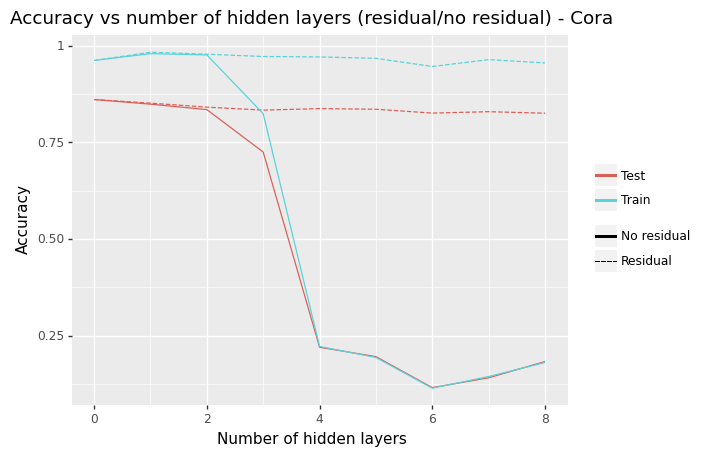

<ggplot: (-9223363252196151580)>


In [17]:
plot_residual_effect(df_cora, Dataset.Cora)

In [18]:
%%capture
df_citeseer = compute_residual_effect_df(Dataset.CiteSeer)

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


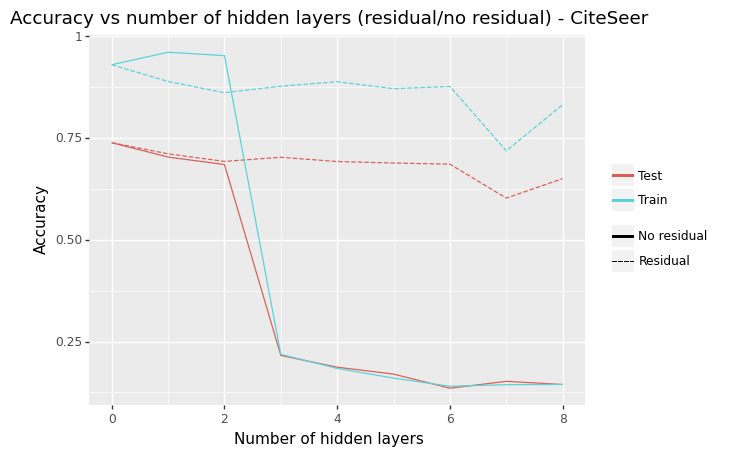

<ggplot: (8784658621206)>


In [19]:
plot_residual_effect(df_citeseer, Dataset.CiteSeer)

In [20]:
%%capture
df_pubmed = compute_residual_effect_df(Dataset.PubMed)

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


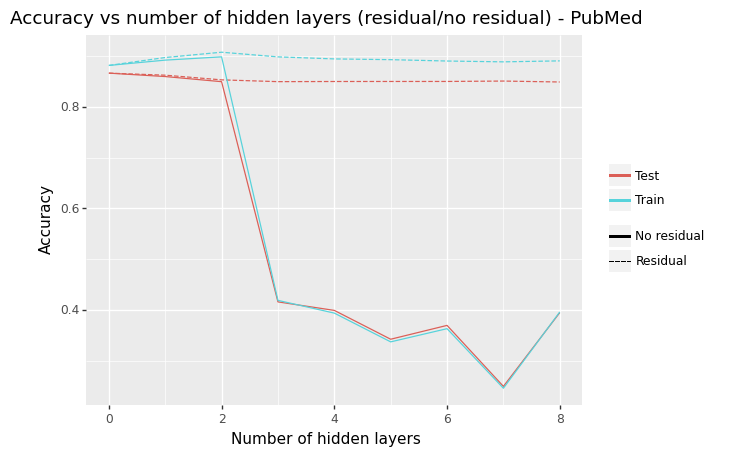

<ggplot: (8784617270080)>


In [21]:
plot_residual_effect(df_pubmed, Dataset.PubMed)